In [1]:
import pandas as pd
import jax.numpy as jnp
from jax import grad, jit, random
from jax.example_libraries import optimizers
import matplotlib.pyplot as plt

In [2]:
# Import data from csv
measurements = pd.read_csv('measurements.csv', header=None)

# Display first few rows
measurements.head()

,0,1
0,0.000000,1.000515
1,0.006289,0.998845
2,0.012579,0.994080
3,0.018868,0.992024
4,0.025158,0.982159


In [3]:
# Create arrays and reshape into 2D columns
time_data = jnp.array(measurements.iloc[:, 0]).reshape(-1, 1)
voltage_data = jnp.array(measurements.iloc[:, 1]).reshape(-1, 1)

In [4]:
# Define the neural network 
def nn(params, inputs):
    for W, b in params[:-1]:
        outputs = jnp.dot(inputs, W) + b
        inputs = jnp.tanh(outputs)
    final_W, final_b = params[-1]
    outputs = jnp.dot(inputs, final_W) + final_b
    return outputs

In [5]:
# Define the loss function
def loss(params, inputs, targets):
    predictions = nn(params, inputs)
    return jnp.mean((predictions - targets) ** 2)

In [6]:
key = random.PRNGKey(0)

In [7]:
# Initialize parameters
input_size = time_data.shape[1] if time_data.ndim > 1 else 1
layer_sizes = [input_size, 32, 32, 1]
params = []
for i in range(len(layer_sizes) - 1):
    output_size = layer_sizes[i + 1]
    W = 0.01 * random.normal(key, (layer_sizes[i], output_size))
    b = jnp.zeros(output_size)
    params.append((W, b))

In [8]:
# JIT compile the forward and backward passes
jit_loss = jit(loss)
jit_grad = jit(grad(loss))

In [9]:
# Define optimizer
step_size = 0.01
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

In [10]:
# Define a compiled update step
@jit
def update(i, opt_state, x, y):
    params = get_params(opt_state)
    grads = jit_grad(params, x, y)
    return opt_update(i, grads, opt_state)

In [11]:
# Number of epochs
num_epochs = 100000

# Perform the training loop
for epoch in range(num_epochs):
    opt_state = update(epoch, opt_state, time_data, voltage_data)
    if epoch % 10000 == 0:
        params = get_params(opt_state)
        loss_val = jit_loss(params, time_data, voltage_data)
        print(f'Epoch {epoch}, Loss: {loss_val:.6f}')

Epoch 0, Loss: 0.044415
Epoch 10000, Loss: 0.001478
Epoch 20000, Loss: 0.000157
Epoch 30000, Loss: 0.000048
Epoch 40000, Loss: 0.000060
Epoch 50000, Loss: 0.000116
Epoch 60000, Loss: 0.000706
Epoch 70000, Loss: 0.000018
Epoch 80000, Loss: 0.000016
Epoch 90000, Loss: 0.000016


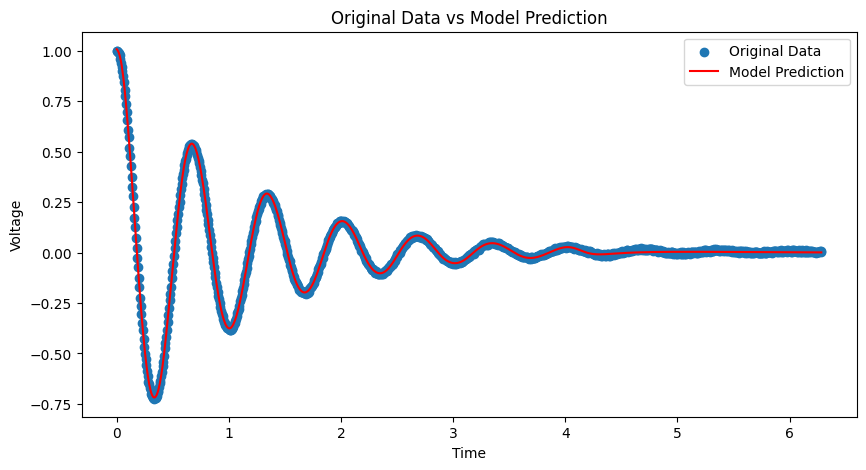

In [12]:
# Plot the results (Original Data vs Model Prediction)
trained_params = get_params(opt_state)
plt.figure(figsize=(10, 5))
plt.scatter(time_data, voltage_data, label='Original Data')
plt.plot(time_data, nn(trained_params, time_data), color='red', label='Model Prediction')
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.title('Original Data vs Model Prediction')
plt.legend()
plt.show()

## Approximation of outputs of analog circuits using neural networks

In this project, I used the JAX library to create a neural network model that matched voltage readings in a circuit over time. I chose the JAX library because of its numerical computing efficiency and robust automated differentiation capabilities, both of which are critical for deep learning applications.

**Parameterization of the model:**

In my technique, I built a neural network design with an input layer, two hidden layers of 32 neurons each, and an output layer. I picked the tanh activation function for hidden layers. This choice was made based on the tanh function's capacity to capture non-linear connections as well as its original range (-1, 1), which is especially useful for normalizing data.

I set the network parameters to modest random values, especially scaled by 0.01, to avoid symmetry during the learning phase and favor efficient learning progress.

**Justification of the function:**

The tanh activation functions were perfect for my model due to their non-linear character and output range, which corresponded to the normalized voltage data scale. This allows for the investigation of complicated patterns in measurements.

**Model training:**

I trained the model for 100,000 epochs, which may appear to be a large number, but it was important to verify that the model properly learnt the underlying patterns in the data. The mean squared error (MSE) loss function, which is common in regression models, was employed, and I used JIT JAX compilation to accelerate the training process.

**Results and scheme analysis:**

After training, I checked the model's voltage predictions against the raw data. The results were highly encouraging, with the predictions nearly matching the actual observations. The loss function's convergence to a minimal value implies that the model's predicting is highly accurate.

**Conclusion:**

The neural network topology and parameterization that I used proved to be quite helpful for this modeling endeavor. While the network reliably predicts voltage, it does not give direct information about the circuit's physical qualities. However, the model's accuracy suggests a steady and predictable connection between time and voltage, which is consistent with the physical features of the circuit components. More research, including a physical examination of the circuit, would be necessary to have a more complete understanding.

## Optimization considerations for analyzing processor-bound analog circuits

In a project that required evaluating analog circuits, I picked the JAX library because to its efficiency and compatibility with CPU-based computations. I've shown below why this was a superior option for lower-level languages like assembly.

**JAX Performance in High Performance Computing**

JAX is especially well-suited for activities that need large numerical computations, such as matrix manipulations and gradient calculations. The library's ability to leverage just-in-time (JIT) compilation via XLA (Accelerated Linear Algebra) is critical for various reasons.

- **Speed Optimization:** JAX converts Python and NumPy code into extremely efficient machine code, resulting in much faster execution. This covers standard assembly-level optimizations like vectorization and parallelization.

- **Automatic Differentiation:** An essential prerequisite for neural networks is the efficient calculation of gradients for backpropagation. JAX automates this procedure, increasing its speed and precision.

**Disadvantages of assembly language:**

Despite the fine-grained control that assembly language offers, its use is fraught with significant challenges:

- **Complexity and Maintainability:** Assembly code is famously complicated and difficult to maintain. This necessitates in-depth understanding of the hardware and frequently results in less understandable code.

- **Portability issues:** Assembly code is processor-dependent, which creates portability concerns. The lack of portability across multiple hardware architectures might be a severe constraint.

- **Development time:** Writing assembly language takes time. The potential speed advantages may not always be worth the time and effort, especially because libraries like JAX execute many of these optimizations automatically.

To summarize, while assembly language can be useful in some situations, using JAX's capabilities to model an analog circuit with a neural network is a more practical and efficient way. It strikes a mix between speed optimization and code maintainability and readability, all of which are critical to my project's scalability and flexibility.
